## Classic Neural Network for entanglement detection

In this notebook we are going to use fully connected neural network for the task of entanglement detection using observable mean values as features.\
The dataset is imported with pandas and the network is implemented with the torch library.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch as th
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import confusion_matrix, roc_curve, auc

from tqdm.auto import trange


import seaborn as sns

### Dataset

We use the dataset of the quantum observables: the ```ds_haar_obs```.
It's composed by 10 features and 1 label, 0 or 1 if the state is entangled or separable.\
The 10 features represent the means values of some observables (see the dataset folder for an extensive explanation of how the dataset is generated).


Then the dataset is split in train and test part using the hypeparameters define below. 


In [27]:
# Hyperparameters value

N_DATA = 5000
N_TRAIN = 4000
N_TEST = N_DATA - N_TRAIN
BATCH_SIZE = 1
EPOCHS = 10
LEARNING_RATE = 0.001

dataset_U = pd.read_csv('../datasets/ds_mixed_obs.csv') # import the dataset
dataset_U = dataset_U[:N_DATA] # select the number of data

# Separate features (X) and labels (y)

# Drop the 11th column
X = dataset_U.drop(columns=dataset_U.columns[10])
X = np.array(X)
X = th.tensor(X, dtype=th.float32)

y = dataset_U.iloc[:, 10]  # Assuming the label is in the 11th column (index 10)
y = th.tensor(y.to_numpy(dtype=int)) # convert the labels in torch tensor

X = X[:,0:10] # select only some of the features

#train
obs_train = X[:N_TRAIN]
y_train = y[:N_TRAIN]

train_mapped_dataset = TensorDataset(obs_train,y_train) # create dataset
train_mapped_loader = DataLoader(train_mapped_dataset, shuffle=True, batch_size=BATCH_SIZE) # create dataloader for the training


#TEST
obs_test = X[N_TRAIN:N_DATA]
y_test = y[N_TRAIN:N_DATA]

test_mapped_dataset = TensorDataset(obs_test,y_test) # create your datset
test_mapped_loader = DataLoader(test_mapped_dataset, shuffle=False, batch_size=BATCH_SIZE) # create dataloader for the test


### Model

Define the model as an inherint class from the nn.Module of pytorch.
It's define the constructor, i.e. the architecture of the network with:
* input layer 
* hidden layer 
* output layer

Then is the define a function for the forward part of the training in which is applied an activaction function to each layer and return the ouput of the neural network

In [40]:
# Define the neural network model through a class:

#!!! WARNING: Change in the input layer the number of features

class Net_cluster1(nn.Module):

    # define the model with the constructor of the class
    def __init__(self):
        super(Net_cluster1, self).__init__() 
        self.l1 = nn.Linear(in_features = 10 , out_features = 25) # input layer
        self.l2 = nn.Linear(in_features = 25, out_features = 15) # hidden layer
        self.term = nn.Linear(in_features = 15, out_features = 2) # output layer

    # this function is used for the forward training part
    def forward(self, x: th.Tensor) -> th.Tensor:
        
        x : th.Tensor = x.flatten(start_dim=1)
        x : th.Tensor = F.relu(self.l1(x))
        x : th.Tensor  = F.relu(self.l2(x))
        #x : Tensor = F.relu(self.l3(x))
        logits : th.Tensor = self.term(x)
        out: th.Tensor = F.softmax(input=logits, dim=1)

        return out

### Important function

There are some fundamental function below for the learning of the neural network

In [41]:
def get_batch_accuracy(logit, target):
    """
    Obtain accuracy for one batch of data
    Input:
        - logit(torch.tensor): The predictions from the model 
        - target(torch.tensor): The y true values 
    Return:
        - accuracy(float): The value of the accuracy
    
    """
    corrects = (th.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def train_loop(model, train_loader, EPOCHS, optimizer, criterion):
    """
    Function for training the model.
    Input:
        - model(torch model): The neural network
        - train_loader(torch DataLoader): The train dataset passed as a torch DataLoader
        - EPOCHS(int): Number of epochs for the training
        - optimizer(torch optimizer): Optimizer for the learning algorithm
        - criterion(torch loss functions): The loss function for the learning algorithm
    Return: Print the loss and train accuracy and train the model
        - train_history(list): List of values of the train error
        - loss_history(list): List of values of the loss
    """

    train_history = []
    loss_history = []

    # do the training loop through the number of epochs
    for epoch in trange(EPOCHS):
        train_running_loss = 0.0
        train_acc = 0.0

        model = model.train()  # Set the model to training mode: relevant for dropout, batchnorm, etc.

        # Actual (batch-wise) training step
        for i, (images, labels) in enumerate(train_loader):
            # Forward pass + (automated) BackProp + Loss computation
            logits = model(images)
            loss = criterion(logits, labels) # calculate the loss

            optimizer.zero_grad()  # Reset the gradients to zero: otherwise they accumulate!
            loss.backward()  # Backpropagation

            # Update model params
            optimizer.step()

            train_running_loss += loss.detach().item()
            train_acc += get_batch_accuracy(logits, labels)

        loss_history.append(train_running_loss/i)
        train_history.append(train_acc/i)

        model.eval()

        print(f"Epoch: {epoch+1} | Loss: {train_running_loss/i} | Train Accuracy: {train_acc/i}")
    
    return train_history, loss_history


### Trainig and test part 

Here some important things for the training are defined:
* The model
* The loss function
* The optimizer

Then is used the train_loop function for the training part and after is calculated the test accuracy

In [42]:
model = Net_cluster1() # define the model as an object of the model class
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = th.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)  # the optimizer

In [43]:

train_history, loss_history =  train_loop(model, train_mapped_loader, EPOCHS, optimizer, criterion) # training part
print("")

# calculate the test accuracy
test_acc = 0.0
for i, (dens_matr, labels) in enumerate(test_mapped_loader):
    outputs = model(dens_matr)
    test_acc += get_batch_accuracy(outputs, labels)

print(f"Test Accuracy: {test_acc/i}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Loss: 0.6915859241922607 | Train Accuracy: 52.638159539884974
Epoch: 2 | Loss: 0.6551708283797596 | Train Accuracy: 64.51612903225806
Epoch: 3 | Loss: 0.5933945410011351 | Train Accuracy: 71.81795448862215
Epoch: 4 | Loss: 0.5581300970195799 | Train Accuracy: 75.39384846211553
Epoch: 5 | Loss: 0.5394549553887371 | Train Accuracy: 77.26931732933234
Epoch: 6 | Loss: 0.5296228863680831 | Train Accuracy: 77.96949237309327
Epoch: 7 | Loss: 0.5128961006204138 | Train Accuracy: 79.59489872468117
Epoch: 8 | Loss: 0.510773666421006 | Train Accuracy: 79.36984246061516
Epoch: 9 | Loss: 0.5071180381978205 | Train Accuracy: 80.02000500125031
Epoch: 10 | Loss: 0.5016287789624403 | Train Accuracy: 80.39509877469368

Test Accuracy: 82.58258258258259


### Plot


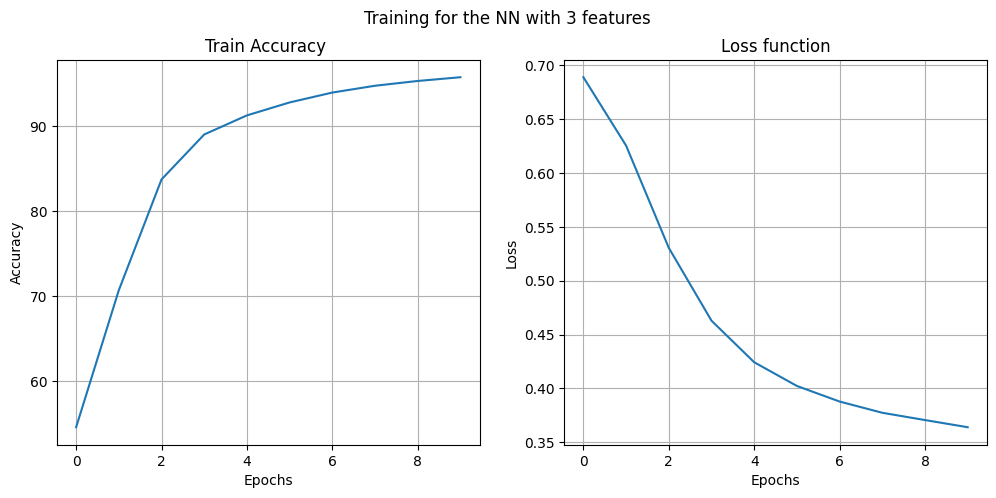

In [56]:
# plot of the train_error vs epochs and loss vs epochs


# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))


axs[0].plot(np.arange(EPOCHS), train_history)
axs[0].set_title('Train Accuracy ')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].grid()

axs[1].plot(np.arange(EPOCHS), loss_history)
axs[1].set_title('Loss function')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].grid()

fig.suptitle('Training for the NN with 3 features')

plt.show()


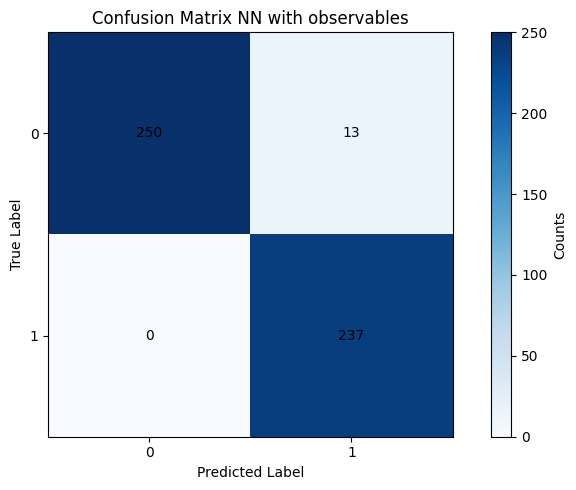

In [93]:
with th.no_grad():
    predictions = model(obs_test)


# Convert predictions to numpy array and binarize (if needed)
predictions_np = (predictions.numpy() > 0.5).astype(int)
y_test_np = y_test.numpy()

predictions_np  = predictions_np[:,1]


# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_np, predictions_np)


# Plot confusion matrix
plt.figure(figsize=(8, 5))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')

# Add labels
plt.title('Confusion Matrix NN with observables')
plt.xticks(np.arange(2), ['0', '1']) # Set x-axis ticks
plt.yticks(np.arange(2), ['0', '1']) # Set y-axis ticks
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar(label='Counts')

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')

plt.tight_layout()
plt.show()



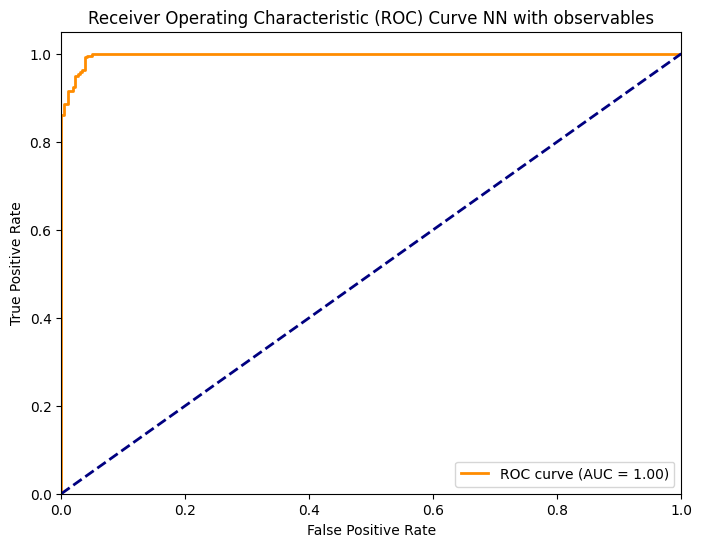

In [95]:
# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])

# Calculate Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve NN with observables')
plt.legend(loc='lower right')
plt.show()